# Lab 15 — Regularization for MLPs

**Objective.** Investigate how different regularization techniques affect the training dynamics and generalization performance of a simple neural network. We will implement and compare:

- **Dropout** — randomly dropping hidden neurons during training
- **L1 and L2 regularization** — penalizing large weights (biases are not regularized)
- **Early stopping** — stop training when validation performance degrades

*Notebook generated on: 2025-11-15 23:08:27*

## 1. Setup & Imports

In [1]:
import torch
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

set_matplotlib_formats('png', 'pdf')
np.random.seed(42)
torch.manual_seed(42)


## 1.1 Data Generation

We use a noisy 2D classification dataset (**moons**) to illustrate overfitting and regularization effects. The training set is moderately noisy; the validation set is cleaner for assessing generalization.

Training set: torch.Size([350, 2]), Validation set: torch.Size([150, 2])


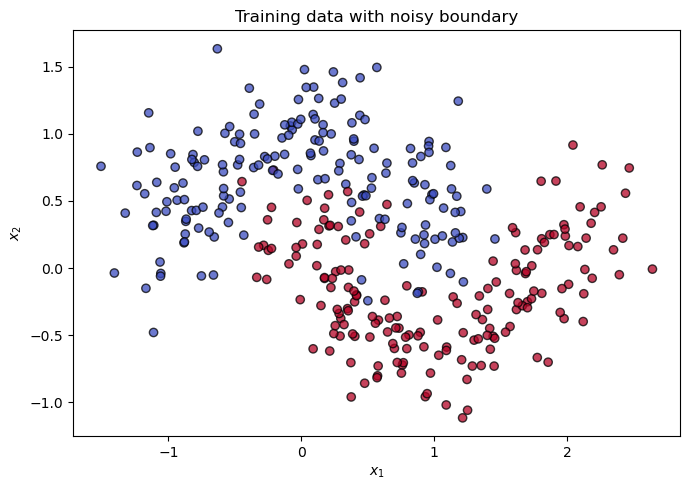

In [2]:
# Create dataset
X, y = make_moons(n_samples=500, noise=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Convert to torch tensors
x_train = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

print(f'Training set: {x_train.shape}, Validation set: {x_val.shape}')

# Visualize training data
plt.figure(figsize=(7,5))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm', alpha=0.75, edgecolor='k')
plt.title('Training data with noisy boundary')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.tight_layout()
plt.show()


## 1.2 Network Architecture and Forward Pass

We implement an MLP with:

- Input: 2 neurons $(x_1, x_2)$
- Hidden layer 1: 20 neurons, **tanh**
- Hidden layer 2: 10 neurons, **tanh**
- Output layer: 1 neuron, **sigmoid** (binary classification)

In [3]:
# Activations

def sigmoid(x: Tensor) -> Tensor:
    return 1 / (1 + torch.exp(-x))

def tanh(x: Tensor) -> Tensor:
    return torch.tanh(x)

# Architecture and parameter helpers
ARCHITECTURE = [2, 20, 10, 1]

def count_parameters(layer_sizes):
    total = 0
    for i in range(len(layer_sizes) - 1):
        n_in, n_out = layer_sizes[i], layer_sizes[i+1]
        total += n_in * n_out + n_out  # weights + biases
    return total

def initialize_parameters(layer_sizes, scale: float = 0.3) -> Tensor:
    n_params = count_parameters(layer_sizes)
    return torch.randn(n_params) * scale

print('Total parameters:', count_parameters(ARCHITECTURE))


Total parameters: 281


### 1.2.1 Exercise 1 — Forward Pass with Dropout (3P)

We implement **inverted dropout** on hidden layers: during training, activations are multiplied by a Bernoulli mask and scaled by $1/(1-p)$ so expected activation magnitude remains unchanged. At evaluation, no dropout is applied.

In [4]:
from typing import Tuple

def predict_with_dropout(
    x: Tensor,
    params: Tensor,
    layer_sizes: list[int],
    dropout_rate: float = 0.0,
    training: bool = True
) -> Tuple[Tensor, dict]:
    cache = {'layer_sizes': layer_sizes}
    activations = [x]

    # Unpack params: per layer -> [bias (n_out), weights (n_in*n_out)]
    idx = 0
    weights, biases = [], []
    for i in range(len(layer_sizes) - 1):
        n_in, n_out = layer_sizes[i], layer_sizes[i+1]
        b = params[idx:idx+n_out]; idx += n_out
        W = params[idx:idx+n_in*n_out].view(n_in, n_out); idx += n_in*n_out
        weights.append(W); biases.append(b)

    for i in range(len(weights)):
        W, b = weights[i], biases[i]
        z_in = activations[-1] @ W + b
        cache[f'z{i}_in'] = z_in

        if i < len(weights) - 1:  # hidden layer: tanh + dropout
            z_out_pre_dropout = tanh(z_in)
            if training and dropout_rate > 0.0:
                mask = (torch.rand_like(z_out_pre_dropout) > dropout_rate).float()
                mask *= 1.0 / (1.0 - dropout_rate)  # inverted dropout scaling
                z_out = z_out_pre_dropout * mask
                cache[f'dropout_mask{i}'] = mask
            else:
                z_out = z_out_pre_dropout
                cache[f'dropout_mask{i}'] = torch.ones_like(z_out)
        else:  # output layer: sigmoid, no dropout
            z_out_pre_dropout = sigmoid(z_in)
            z_out = z_out_pre_dropout

        cache[f'z{i}_out_pre_dropout'] = z_out_pre_dropout
        cache[f'z{i}_out'] = z_out
        cache[f'W{i}'] = W
        cache[f'b{i}'] = b
        activations.append(z_out)

    cache['activations'] = activations
    cache['dropout_rate'] = dropout_rate
    return activations[-1], cache

# Quick test
params = initialize_parameters(ARCHITECTURE)
predictions, cache = predict_with_dropout(x_train, params, ARCHITECTURE, dropout_rate=0.0, training=False)
print('Forward pass OK. Predictions shape:', predictions.shape)


Forward pass OK. Predictions shape: torch.Size([350, 1])


## 1.3 Exercise 2 — Loss Function with Regularization (2P)
Extend binary cross-entropy with **L1 (sparsity)** and **L2 (weight decay)** on weights only.

In [5]:
def get_loss_with_regularization(
    target: Tensor,
    pred: Tensor,
    params: Tensor,
    layer_sizes: list[int],
    lambda_l1: float = 0.0,
    lambda_l2: float = 0.0
) -> Tensor:
    # Align shapes
    if target.dim() == 1 and pred.dim() == 2:
        target = target.unsqueeze(1)
    elif target.dim() == 2 and pred.dim() == 1:
        pred = pred.unsqueeze(1)

    eps = 1e-15
    data_loss = -torch.mean(target * torch.log(pred + eps) + (1 - target) * torch.log(1 - pred + eps))

    # Extract weights (skip biases)
    idx = 0
    W_list = []
    for i in range(len(layer_sizes) - 1):
        n_in, n_out = layer_sizes[i], layer_sizes[i+1]
        idx += n_out  # skip bias
        W = params[idx:idx+n_in*n_out].view(n_in, n_out); idx += n_in*n_out
        W_list.append(W)

    l1_term = sum(torch.sum(torch.abs(W)) for W in W_list) * lambda_l1 if lambda_l1 else 0.0
    l2_term = sum(torch.sum(W*W) for W in W_list) * lambda_l2 if lambda_l2 else 0.0

    return data_loss + l1_term + l2_term


## 1.4 Exercise 3 — Backpropagation with Dropout and Regularization (3P)
Backprop through the MLP, apply stored dropout masks (inverted dropout) to upstream gradients, and add L1/L2 terms to **weight** gradients (biases not regularized).

In [6]:
def get_gradients_with_regularization(
    target: Tensor,
    cache: dict,
    params: Tensor,
    lambda_l1: float = 0.0,
    lambda_l2: float = 0.0,
    dropout_rate: float = 0.0
) -> Tensor:
    layer_sizes = cache['layer_sizes']
    activations = cache['activations']
    n_layers = len(layer_sizes) - 1
    N = activations[0].shape[0]

    fout = activations[-1]
    if target.dim() == 1:
        target = target.unsqueeze(1)

    eps = 1e-15
    dL_dfout = -target / (fout + eps) + (1 - target) / (1 - fout + eps)
    dfout_dfin = fout * (1 - fout)
    dL_dz = dL_dfout * dfout_dfin

    grads = []
    for i in range(n_layers - 1, -1, -1):
        W = cache[f'W{i}']
        z_prev = activations[i]

        dL_db = torch.mean(dL_dz, dim=0)
        dL_dW = (z_prev.T @ dL_dz) / N

        if lambda_l1 != 0.0:
            dL_dW = dL_dW + lambda_l1 * torch.sign(W)
        if lambda_l2 != 0.0:
            dL_dW = dL_dW + 2.0 * lambda_l2 * W

        grads.append((dL_db, dL_dW))

        if i > 0:
            dL_dz_prev = dL_dz @ W.T
            mask_prev = cache.get(f'dropout_mask{i-1}', None)
            if mask_prev is not None:
                dL_dz_prev = dL_dz_prev * mask_prev
            z_prev_in = cache[f'z{i-1}_in']
            dz_prev_out = 1.0 - torch.tanh(z_prev_in)**2
            dL_dz = dL_dz_prev * dz_prev_out

    grads = grads[::-1]
    flat = []
    for dL_db, dL_dW in grads:
        flat.append(dL_db)
        flat.append(dL_dW.flatten())
    return torch.cat(flat)


## 1.5 Exercise 4 — Training with Early Stopping (2P)
SGD training loop with patience-based early stopping on validation loss. Returns best parameters and a history dictionary for plotting.

In [7]:
def train_network(
    x_train: Tensor,
    y_train: Tensor,
    x_val: Tensor,
    y_val: Tensor,
    layer_sizes: list[int],
    learning_rate: float = 0.5,
    max_steps: int = 1000,
    dropout_rate: float = 0.0,
    lambda_l1: float = 0.0,
    lambda_l2: float = 0.0,
    patience: int = 50,
    verbose: bool = False
) -> tuple[Tensor, dict]:
    params = initialize_parameters(layer_sizes)
    best_params = params.clone()
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    history = {'train_loss': [], 'val_loss': []}

    for step in range(1, max_steps + 1):
        pred_train, cache = predict_with_dropout(
            x_train, params, layer_sizes, dropout_rate=dropout_rate, training=True
        )
        loss_train = get_loss_with_regularization(
            y_train, pred_train, params, layer_sizes, lambda_l1=lambda_l1, lambda_l2=lambda_l2
        )
        grads = get_gradients_with_regularization(
            y_train, cache, params, lambda_l1=lambda_l1, lambda_l2=lambda_l2, dropout_rate=dropout_rate
        )
        params = params - learning_rate * grads

        with torch.no_grad():
            pred_val, _ = predict_with_dropout(
                x_val, params, layer_sizes, dropout_rate=dropout_rate, training=False
            )
            loss_val = get_loss_with_regularization(
                y_val, pred_val, params, layer_sizes, lambda_l1=lambda_l1, lambda_l2=lambda_l2
            )

        history['train_loss'].append(loss_train.item())
        history['val_loss'].append(loss_val.item())

        if loss_val.item() + 1e-10 < best_val_loss:
            best_val_loss = loss_val.item()
            best_params = params.clone()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if verbose and (step % 100 == 0 or step == 1):
            print(f'Step {step:4d} | Train Loss: {loss_train.item():.4f} | Val Loss: {loss_val.item():.4f}')

        if epochs_without_improvement >= patience:
            if verbose:
                print(f'Early stopping at step {step} (no improvement for {patience} steps). Best val loss: {best_val_loss:.4f}')
            break

    return best_params, history


## 1.6 Compare Regularization Techniques
Train four models: **Baseline**, **Dropout**, **L1**, **L2**.

In [8]:
params_baseline, history_baseline = train_network(
    x_train, y_train_t, x_val, y_val_t,
    layer_sizes=ARCHITECTURE,
    learning_rate=0.5, max_steps=2000, patience=500
)
params_dropout, history_dropout = train_network(
    x_train, y_train_t, x_val, y_val_t,
    layer_sizes=ARCHITECTURE,
    learning_rate=0.5, max_steps=2000, dropout_rate=0.15, patience=200
)
params_l1, history_l1 = train_network(
    x_train, y_train_t, x_val, y_val_t,
    layer_sizes=ARCHITECTURE,
    learning_rate=0.5, max_steps=2000, lambda_l1=0.002, patience=200
)
params_l2, history_l2 = train_network(
    x_train, y_train_t, x_val, y_val_t,
    layer_sizes=ARCHITECTURE,
    learning_rate=0.5, max_steps=2000, lambda_l2=0.005, patience=200
)


## 1.7 Visualization
Plot training/validation loss for each technique.

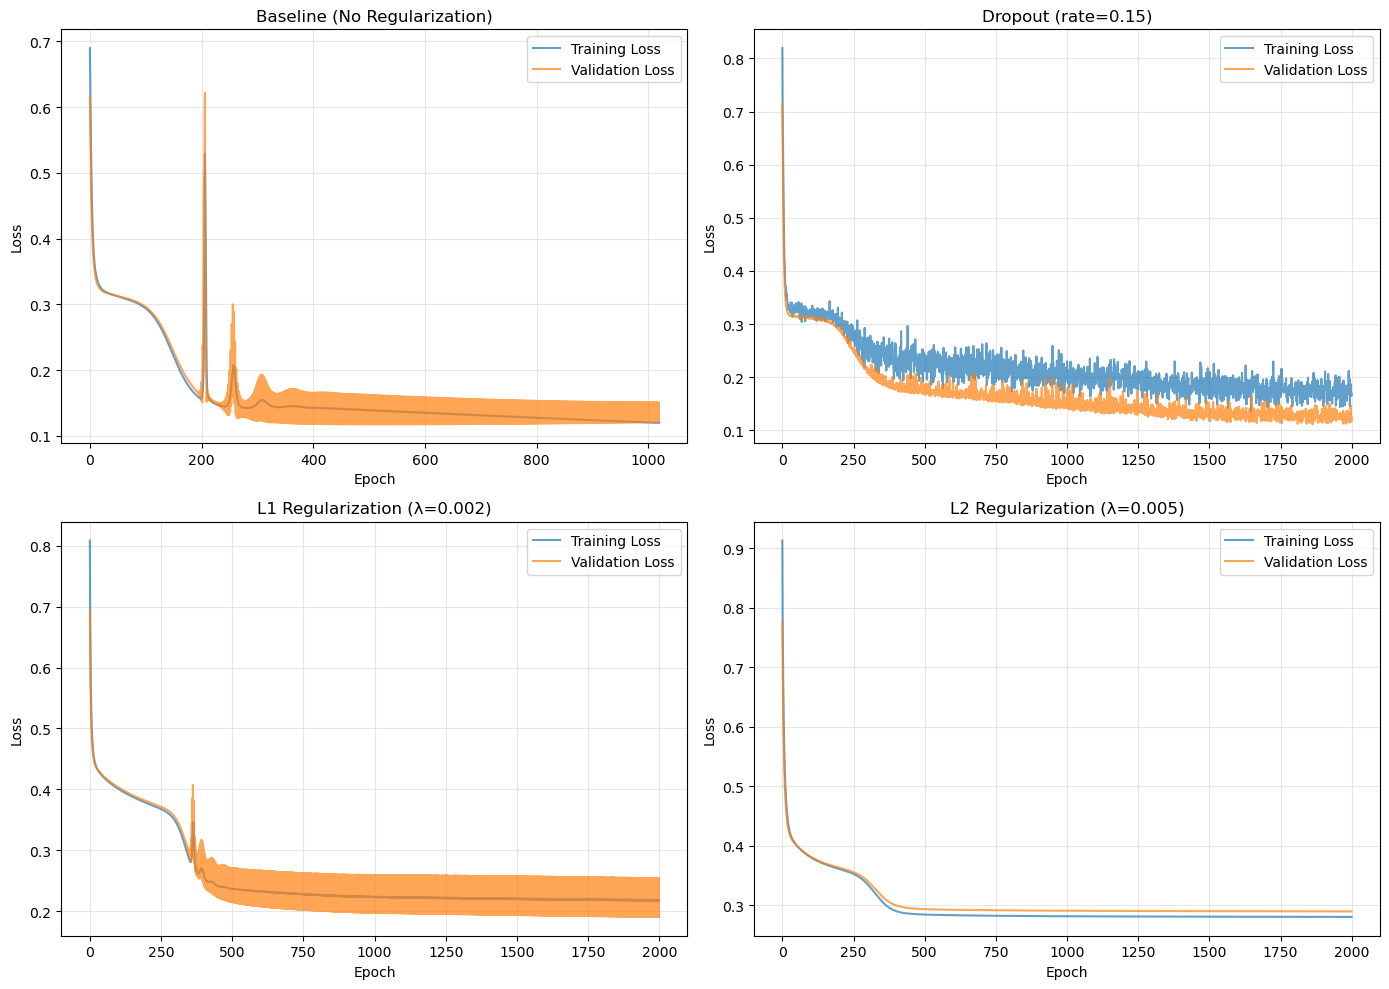

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = [
    ("Baseline (No Regularization)", history_baseline),
    ("Dropout (rate=0.15)", history_dropout),
    ("L1 Regularization (λ=0.002)", history_l1),
    ("L2 Regularization (λ=0.005)", history_l2)
]

for idx, (name, history) in enumerate(models):
    ax = axes[idx // 2, idx % 2]
    ax.plot(history['train_loss'], label='Training Loss', alpha=0.7)
    ax.plot(history['val_loss'], label='Validation Loss', alpha=0.7)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(name)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


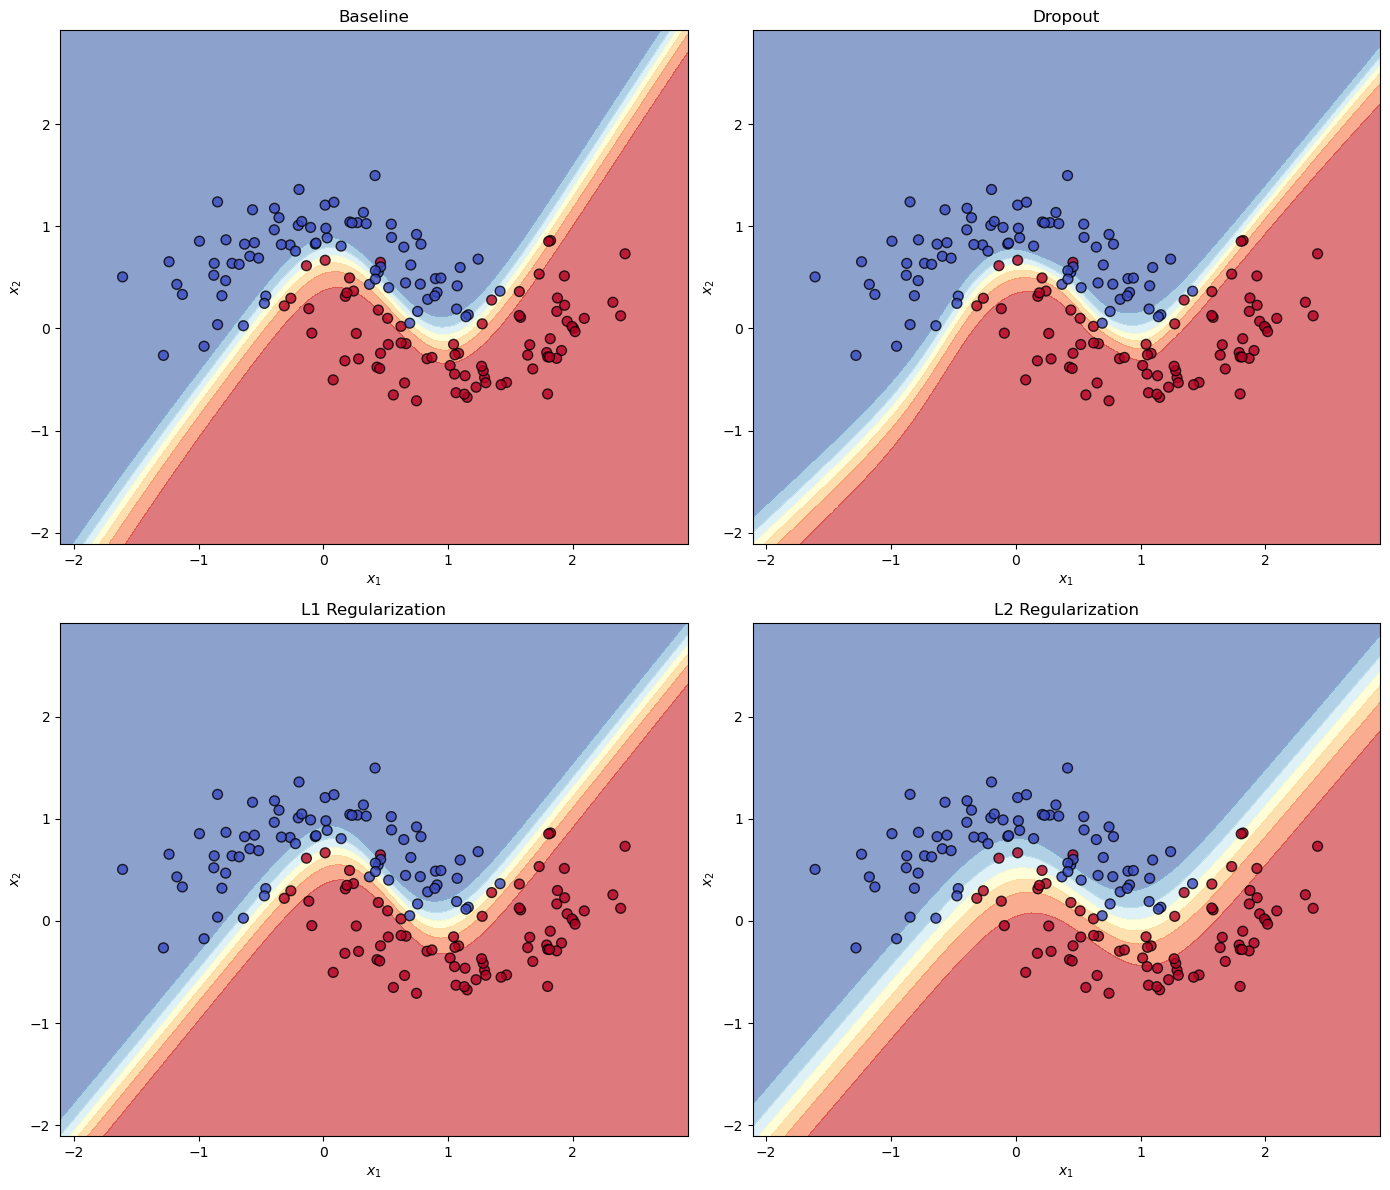

In [10]:
def plot_decision_boundary(ax, x_data, y_data, params, layer_sizes, title):
    """Plot decision boundary for a trained network."""
    # Create grid
    grid_range = torch.linspace(x_data.min()-0.5, x_data.max()+0.5, 100)
    grid_x, grid_y = torch.meshgrid(grid_range, grid_range, indexing='xy')
    grid_data = torch.stack([grid_x.flatten(), grid_y.flatten()]).T
    
    # Get predictions
    pred, _ = predict_with_dropout(
        grid_data, params, layer_sizes,
        dropout_rate=0.0, training=False
    )
    pred = pred.view(grid_x.shape).detach().numpy()
    
    # Plot
    ax.contourf(grid_x.numpy(), grid_y.numpy(), pred, cmap='RdYlBu_r', alpha=0.6)
    ax.scatter(x_data[:, 0], x_data[:, 1], c=y_data, cmap='coolwarm', 
               edgecolor='k', s=50, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

# Plot all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

model_params = [
    ("Baseline", params_baseline),
    ("Dropout", params_dropout),
    ("L1 Regularization", params_l1),
    ("L2 Regularization", params_l2)
]

for idx, (name, params) in enumerate(model_params):
    ax = axes[idx // 2, idx % 2]
    plot_decision_boundary(ax, x_val, y_val_t.numpy(), params, ARCHITECTURE, name)

plt.tight_layout()
plt.show()